In [0]:
!pip install torch torchvision

    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6122c000 @  0x7f555bc722a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 25.5MB/s 
    100% |████████████████████████████████| 2.0MB 6.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
# Load zip from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
#!unzip gdrive/My\ Drive/data_semantics.zip
!unzip gdrive/My\ Drive/CamVid.zip

In [0]:
#os.chdir('./content/')
!ls

gdrive	sample_data  testing  training


In [0]:
!tar -xvzf gdrive/My\ Drive/iccv09Data.tar.gz

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm
from PIL import Image

In [0]:
class InitialBlock(nn.Module):
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

In [0]:
class UBNeck(nn.Module):
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # Concat
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class RDDNeck(nn.Module):
    def __init__(self, dilate, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilate = dilate
        self.down_flag = down_flag

        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilate,
                                  bias = True,
                                  dilation = self.dilate)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [0]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class ENet(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        self.C = C
        
        self.init = InitialBlock()
        
        self.b10 = RDDNeck(1, 16, 64, True, p=0.01)
        self.b11 = RDDNeck(1, 64, 64, False, p=0.01)
        self.b12 = RDDNeck(1, 64, 64, False, p=0.01)
        self.b13 = RDDNeck(1, 64, 64, False, p=0.01)
        self.b14 = RDDNeck(1, 64, 64, False, p=0.01)
        
        self.b20 = RDDNeck(1, 64, 128, True)
        self.b21 = RDDNeck(1, 128, 128, False)
        self.b22 = RDDNeck(2, 128, 128, False)
        self.b23 = ASNeck(128, 128)
        self.b24 = RDDNeck(4, 128, 128, False)
        self.b25 = RDDNeck(1, 128, 128, False)
        self.b26 = RDDNeck(8, 128, 128, False)
        self.b27 = ASNeck(128, 128)
        self.b28 = RDDNeck(16, 128, 128, False)
        
        self.b31 = RDDNeck(1, 128, 128, False)
        self.b32 = RDDNeck(2, 128, 128, False)
        self.b33 = ASNeck(128, 128)
        self.b34 = RDDNeck(4, 128, 128, False)
        self.b35 = RDDNeck(1, 128, 128, False)
        self.b36 = RDDNeck(8, 128, 128, False)
        self.b37 = ASNeck(128, 128)
        self.b38 = RDDNeck(16, 128, 128, False)
        
        self.b40 = UBNeck(128, 64, relu=True)
        self.b41 = RDDNeck(1, 64, 64, False, relu=True)
        self.b42 = RDDNeck(1, 64, 64, False, relu=True)
        
        self.b50 = UBNeck(64, 16, relu=True)
        self.b51 = RDDNeck(1, 16, 16, False, relu=True)
        
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
    def forward(self, x):
        
        x = self.init(x)
        
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        x = self.b50(x, i1)
        x = self.b51(x)
        
        x = self.fullconv(x)
        
        return x

In [0]:
color_map = [
    (  0,  0,  0) ,
    (111, 74,  0) ,
    ( 81,  0, 81) ,
    (128, 64,128) ,
    (244, 35,232) ,
    (250,170,160) ,
    (230,150,140),
    ( 70, 70, 70) ,
    (102,102,156) ,
    (190,153,153),
    (180,165,180) ,
    (150,100,100) ,
    (150,120, 90) ,
    (153,153,153) ,
    (250,170, 30),
    (220,220,  0),
    (107,142, 35),
    (152,251,152),
    ( 70,130,180),
    (220, 20, 60),
    (255,  0,  0),
    (  0,  0,142),
    (  0,  0, 70),
    (  0, 60,100),
    (  0,  0, 90),
    (  0,  0,110),
    (  0, 80,100),
    (  0,  0,230),
    (119, 11, 32)
]

In [0]:
def create_mask(img):
  color_map = [
    (  0,  0,  0) ,
    (  0,  0,  0) ,
    (  0,  0,  0) ,
    (  0,  0,  0) ,
    (  0,  0,  0) ,
    (111, 74,  0) ,
    ( 81,  0, 81) ,
    (128, 64,128) ,
    (244, 35,232) ,
    (250,170,160) ,
    (230,150,140),
    ( 70, 70, 70) ,
    (102,102,156) ,
    (190,153,153),
    (180,165,180) ,
    (150,100,100) ,
    (150,120, 90) ,
    (153,153,153) ,
    (153,153,153) ,
    (250,170, 30),
    (220,220,  0),
    (107,142, 35),
    (152,251,152),
    ( 70,130,180),
    (220, 20, 60),
    (255,  0,  0),
    (  0,  0,142),
    (  0,  0, 70),
    (  0, 60,100),
    (  0,  0, 90),
    (  0,  0,110),
    (  0, 80,100),
    (  0,  0,230),
    (119, 11, 32)
]

  mask = []
  for i in color_map:
    color_img = []
    for j in range(3):
      color_img.append(np.ones((img.shape[:-1])) * i[j]) 
    
    img2 = np.array(color_img, dtype=np.uint8).transpose(1, 2, 0)
    
    mask.append(np.uint8((img == img2).sum(axis = -1) == 3))
  return np.array(mask)

In [0]:
def read_resized_imgs(ImageDirPath,Semantic_flag):
  #os.chdir(ImageDirPath)
  images = []
  for i in os.listdir(ImageDirPath):
    if '.png' in i:
      img = cv2.cvtColor(cv2.imread(ImageDirPath + i), cv2.COLOR_BGR2RGB)
      img = cv2.resize(img,(640, 360), cv2.INTER_CUBIC)
      images.append(img)
      
  if Semantic_flag:
    images = list(map(create_mask, images))
    
  return np.array(images)

In [0]:
def data_pipeline(images,images_mask, batch_size = 16):
    while(1):
        batch_indx = np.random.randint(0,images.shape[0]-1,batch_size)
        #inputs, labels = 
        yield(torch.from_numpy(images[batch_indx]).transpose(2, 3).transpose(1, 2), 
              torch.from_numpy(images_mask[batch_indx]))

In [0]:
images = read_resized_imgs('/content/training/image_2/', False)
images_mask = read_resized_imgs('/content/training/semantic_rgb/', True)

In [0]:
enet2 = ENet(12)
state_dict = torch.load('/content/ckpt-enet-1.pth')['state_dict']
enet2.load_state_dict(state_dict)

In [0]:
enet = ENet(12)

In [0]:
lr = 5e-4
#lr = 1e-4 
batch_size = 10

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
enet = enet.to(device)

In [0]:
def get_class_weights(num_classes, c=1.02):
    #pipe = loader('/content/training/image_2/', '/content/training/semantic/', batch_size=200)
    pipe = loader('/content/train/', '/content/trainannot/', batch_size='all')
    _, labels = next(pipe)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [0]:
class_weights = get_class_weights(12)

In [0]:
class_weights

array([ 5.80019548,  4.55703897, 32.40517924,  3.42039728, 16.23300006,
        8.88810365, 30.99465587, 30.81923596, 13.10949939, 36.42251058,
       42.40738644, 18.29783699])

In [0]:
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)

#scheduler = StepLR(optimizer, step_size=300, gamma=1e-1)

In [0]:
CUDA_LAUNCH_BLOCKING=1

In [0]:
#0

cuda =  torch.cuda.is_available()

print_every = 5
eval_every = 5
train_losses = []
eval_losses = []

#batch_count = images.shape[0] // batch_size
bc_train = 367 // batch_size
bc_eval = 101 // batch_size

#pipe = data_pipeline(images, images_mask, batch_size)
pipe = loader('/content/train/', '/content/trainannot/', batch_size)
eval_pipe = loader('/content/val/', '/content/valannot/', batch_size)

epochs = 250
    
for e in range(1, epochs+1):
    
    
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    enet.train()
    
    #scheduler.step()
    
    
    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)
        
        #assert (X_batch >= 0. and X_batch <= 1.0).all()
        
        if cuda:
            X_batch, mask_batch = X_batch.cuda(), mask_batch.cuda()

        optimizer.zero_grad()

        out = enet(X_batch.float())

        loss = criterion(out, mask_batch.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        
    print ()
    train_losses.append(train_loss)
    
    #if (e+1) % print_every == 0:
    if 5 % print_every == 0:

        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))
    
    
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0
            
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                
                inputs, labels = inputs.to(device), labels.to(device)
                    
                
                out = enet(inputs)
                
                out = out.data.max(1)[1]
                
                eval_loss += (labels.long() - out.long()).sum()
                
            
            print ()
            print ('Loss {:6f}'.format(eval_loss))
            
            eval_losses.append(eval_loss)
        
    if e % print_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict()
        }
        torch.save(checkpoint, '/content/ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print ('Model saved!')

print ('Epoch {}/{}...'.format(e+1, epochs),
       'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))

  0%|          | 0/36 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 1/250... Loss 87.971470
--------------- Epoch 2 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 2/250... Loss 80.500158
--------------- Epoch 3 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 3/250... Loss 70.848118
--------------- Epoch 4 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 4/250... Loss 63.655439
--------------- Epoch 5 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 5/250... Loss 59.472860


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 8179648.000000
Model saved!
--------------- Epoch 6 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 6/250... Loss 55.861719
--------------- Epoch 7 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 7/250... Loss 53.155433
--------------- Epoch 8 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 8/250... Loss 49.916195
--------------- Epoch 9 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 9/250... Loss 48.472949
--------------- Epoch 10 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 10/250... Loss 47.752303


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -31978693.000000
Model saved!
--------------- Epoch 11 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 11/250... Loss 46.932886
--------------- Epoch 12 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 12/250... Loss 47.382366
--------------- Epoch 13 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 13/250... Loss 44.274159
--------------- Epoch 14 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 14/250... Loss 43.000773
--------------- Epoch 15 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 15/250... Loss 41.934540


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -93624250.000000
Model saved!
--------------- Epoch 16 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 16/250... Loss 40.084750
--------------- Epoch 17 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 17/250... Loss 39.615431
--------------- Epoch 18 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 18/250... Loss 39.662673
--------------- Epoch 19 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 19/250... Loss 38.431872
--------------- Epoch 20 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 20/250... Loss 38.071406


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -95008157.000000
Model saved!
--------------- Epoch 21 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 21/250... Loss 37.254095
--------------- Epoch 22 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 22/250... Loss 36.097045
--------------- Epoch 23 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 23/250... Loss 36.276032
--------------- Epoch 24 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 24/250... Loss 34.977716
--------------- Epoch 25 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 25/250... Loss 35.067633


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -142389281.000000
Model saved!
--------------- Epoch 26 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 26/250... Loss 34.892913
--------------- Epoch 27 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 27/250... Loss 33.782736
--------------- Epoch 28 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 28/250... Loss 32.937750
--------------- Epoch 29 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 29/250... Loss 33.423291
--------------- Epoch 30 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 30/250... Loss 33.403220


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -101623497.000000
Model saved!
--------------- Epoch 31 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 31/250... Loss 32.341419
--------------- Epoch 32 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 32/250... Loss 31.565536
--------------- Epoch 33 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 33/250... Loss 31.531168
--------------- Epoch 34 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 34/250... Loss 31.541694
--------------- Epoch 35 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 35/250... Loss 31.204154


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -76650401.000000
Model saved!
--------------- Epoch 36 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 36/250... Loss 30.088840
--------------- Epoch 37 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 37/250... Loss 30.020194
--------------- Epoch 38 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 38/250... Loss 29.248809
--------------- Epoch 39 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 39/250... Loss 29.084930
--------------- Epoch 40 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 40/250... Loss 28.719102


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -67607245.000000
Model saved!
--------------- Epoch 41 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 41/250... Loss 28.293042
--------------- Epoch 42 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 42/250... Loss 27.275168
--------------- Epoch 43 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 43/250... Loss 28.030627
--------------- Epoch 44 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 44/250... Loss 26.925417
--------------- Epoch 45 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 45/250... Loss 25.897733


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -79026681.000000
Model saved!
--------------- Epoch 46 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 46/250... Loss 27.569664
--------------- Epoch 47 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 47/250... Loss 26.160762
--------------- Epoch 48 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 48/250... Loss 26.657630
--------------- Epoch 49 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 49/250... Loss 25.683731
--------------- Epoch 50 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 50/250... Loss 25.021787


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -40499720.000000
Model saved!
--------------- Epoch 51 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 51/250... Loss 24.946746
--------------- Epoch 52 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 52/250... Loss 24.704812
--------------- Epoch 53 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 53/250... Loss 24.440721
--------------- Epoch 54 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 54/250... Loss 24.297192
--------------- Epoch 55 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 55/250... Loss 23.457924


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -21673927.000000
Model saved!
--------------- Epoch 56 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 56/250... Loss 23.586043
--------------- Epoch 57 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 57/250... Loss 22.634940
--------------- Epoch 58 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 58/250... Loss 22.753854
--------------- Epoch 59 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 59/250... Loss 22.391466
--------------- Epoch 60 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 60/250... Loss 22.355707


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -18539980.000000
Model saved!
--------------- Epoch 61 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 61/250... Loss 22.530783
--------------- Epoch 62 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 62/250... Loss 21.764059
--------------- Epoch 63 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 63/250... Loss 22.388778
--------------- Epoch 64 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 64/250... Loss 21.202627
--------------- Epoch 65 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 65/250... Loss 21.069679


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -11960644.000000
Model saved!
--------------- Epoch 66 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 66/250... Loss 21.271122
--------------- Epoch 67 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 67/250... Loss 21.097095
--------------- Epoch 68 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 68/250... Loss 20.573184
--------------- Epoch 69 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 69/250... Loss 20.725996
--------------- Epoch 70 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 70/250... Loss 20.191561


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -17401029.000000
Model saved!
--------------- Epoch 71 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 71/250... Loss 20.012802
--------------- Epoch 72 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 72/250... Loss 20.485794
--------------- Epoch 73 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 73/250... Loss 20.629087
--------------- Epoch 74 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 74/250... Loss 20.108478
--------------- Epoch 75 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 75/250... Loss 20.043152


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -2185499.000000
Model saved!
--------------- Epoch 76 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 76/250... Loss 19.913874
--------------- Epoch 77 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 77/250... Loss 19.024467
--------------- Epoch 78 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 78/250... Loss 19.241448
--------------- Epoch 79 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 79/250... Loss 19.346064
--------------- Epoch 80 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 80/250... Loss 18.638999


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -6623480.000000
Model saved!
--------------- Epoch 81 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 81/250... Loss 18.544913
--------------- Epoch 82 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 82/250... Loss 18.794187
--------------- Epoch 83 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 83/250... Loss 18.771571
--------------- Epoch 84 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 84/250... Loss 18.784003
--------------- Epoch 85 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 85/250... Loss 19.201990


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 1328211.000000
Model saved!
--------------- Epoch 86 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 86/250... Loss 19.389996
--------------- Epoch 87 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 87/250... Loss 18.351727
--------------- Epoch 88 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 88/250... Loss 18.496900
--------------- Epoch 89 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 89/250... Loss 18.063074
--------------- Epoch 90 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 90/250... Loss 17.725680


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 800740.000000
Model saved!
--------------- Epoch 91 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 91/250... Loss 17.637451
--------------- Epoch 92 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 92/250... Loss 17.869771
--------------- Epoch 93 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 93/250... Loss 17.260331
--------------- Epoch 94 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 94/250... Loss 17.466877
--------------- Epoch 95 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 95/250... Loss 17.443088


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 5471159.000000
Model saved!
--------------- Epoch 96 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 96/250... Loss 18.209337
--------------- Epoch 97 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 97/250... Loss 17.368805
--------------- Epoch 98 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 98/250... Loss 17.211636
--------------- Epoch 99 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 99/250... Loss 16.390132
--------------- Epoch 100 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 100/250... Loss 17.160305


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -8794964.000000
Model saved!
--------------- Epoch 101 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 101/250... Loss 16.365200
--------------- Epoch 102 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 102/250... Loss 16.815648
--------------- Epoch 103 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 103/250... Loss 16.414329
--------------- Epoch 104 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 104/250... Loss 16.930363
--------------- Epoch 105 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 105/250... Loss 17.634700


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -23492340.000000
Model saved!
--------------- Epoch 106 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 106/250... Loss 16.793035
--------------- Epoch 107 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 107/250... Loss 17.072552
--------------- Epoch 108 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 108/250... Loss 16.299148
--------------- Epoch 109 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 109/250... Loss 16.350714
--------------- Epoch 110 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 110/250... Loss 16.274734


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -10551629.000000
Model saved!
--------------- Epoch 111 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 111/250... Loss 16.089356
--------------- Epoch 112 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 112/250... Loss 15.965244
--------------- Epoch 113 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 113/250... Loss 15.869612
--------------- Epoch 114 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 114/250... Loss 15.407345
--------------- Epoch 115 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 115/250... Loss 16.258654


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -3541522.000000
Model saved!
--------------- Epoch 116 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 116/250... Loss 15.418772
--------------- Epoch 117 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 117/250... Loss 14.890808
--------------- Epoch 118 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 118/250... Loss 15.904644
--------------- Epoch 119 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 119/250... Loss 16.045073
--------------- Epoch 120 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 120/250... Loss 16.080071


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -10399512.000000
Model saved!
--------------- Epoch 121 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 121/250... Loss 15.386992
--------------- Epoch 122 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 122/250... Loss 15.373921
--------------- Epoch 123 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 123/250... Loss 15.425706
--------------- Epoch 124 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 124/250... Loss 15.506451
--------------- Epoch 125 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 125/250... Loss 15.333262


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -13767483.000000
Model saved!
--------------- Epoch 126 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 126/250... Loss 15.803168
--------------- Epoch 127 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 127/250... Loss 15.337638
--------------- Epoch 128 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 128/250... Loss 15.422305
--------------- Epoch 129 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 129/250... Loss 15.329869
--------------- Epoch 130 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 130/250... Loss 15.351579


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 24794598.000000
Model saved!
--------------- Epoch 131 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 131/250... Loss 15.162007
--------------- Epoch 132 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 132/250... Loss 14.881930
--------------- Epoch 133 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 133/250... Loss 14.766995
--------------- Epoch 134 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 134/250... Loss 14.765866
--------------- Epoch 135 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 135/250... Loss 15.307853


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 24380594.000000
Model saved!
--------------- Epoch 136 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 136/250... Loss 15.059188
--------------- Epoch 137 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 137/250... Loss 14.937672
--------------- Epoch 138 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 138/250... Loss 15.238168
--------------- Epoch 139 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 139/250... Loss 14.999816
--------------- Epoch 140 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 140/250... Loss 14.661340


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 23402439.000000
Model saved!
--------------- Epoch 141 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 141/250... Loss 14.210115
--------------- Epoch 142 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 142/250... Loss 14.591324
--------------- Epoch 143 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 143/250... Loss 14.148377
--------------- Epoch 144 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 144/250... Loss 13.869635
--------------- Epoch 145 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 145/250... Loss 15.169269


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 16017889.000000
Model saved!
--------------- Epoch 146 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 146/250... Loss 14.499846
--------------- Epoch 147 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 147/250... Loss 14.041239
--------------- Epoch 148 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 148/250... Loss 13.959689
--------------- Epoch 149 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 149/250... Loss 14.271547
--------------- Epoch 150 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 150/250... Loss 14.143121


  0%|          | 0/36 [00:00<?, ?it/s]


Loss -6809431.000000
Model saved!
--------------- Epoch 151 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 151/250... Loss 14.038819
--------------- Epoch 152 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 152/250... Loss 14.217421
--------------- Epoch 153 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 153/250... Loss 15.395277
--------------- Epoch 154 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 154/250... Loss 14.552253
--------------- Epoch 155 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 155/250... Loss 14.347856


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 21693092.000000
Model saved!
--------------- Epoch 156 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 156/250... Loss 13.693540
--------------- Epoch 157 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 157/250... Loss 13.932017
--------------- Epoch 158 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 158/250... Loss 13.981376
--------------- Epoch 159 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 159/250... Loss 13.851171
--------------- Epoch 160 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 160/250... Loss 14.253620


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 24135675.000000
Model saved!
--------------- Epoch 161 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 161/250... Loss 13.927476
--------------- Epoch 162 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 162/250... Loss 13.737588
--------------- Epoch 163 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 163/250... Loss 14.019352
--------------- Epoch 164 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 164/250... Loss 13.577341
--------------- Epoch 165 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 165/250... Loss 14.163371


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 15140203.000000
Model saved!
--------------- Epoch 166 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 166/250... Loss 14.040132
--------------- Epoch 167 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 167/250... Loss 13.584229
--------------- Epoch 168 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 168/250... Loss 13.685897
--------------- Epoch 169 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 169/250... Loss 14.107769
--------------- Epoch 170 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 170/250... Loss 13.956905


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 14970728.000000
Model saved!
--------------- Epoch 171 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 171/250... Loss 13.692625
--------------- Epoch 172 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 172/250... Loss 13.992199
--------------- Epoch 173 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 173/250... Loss 14.124748
--------------- Epoch 174 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 174/250... Loss 13.987469
--------------- Epoch 175 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 175/250... Loss 13.414060


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 32930543.000000
Model saved!
--------------- Epoch 176 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 176/250... Loss 13.723930
--------------- Epoch 177 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 177/250... Loss 13.478100
--------------- Epoch 178 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 178/250... Loss 12.995861
--------------- Epoch 179 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 179/250... Loss 13.632256
--------------- Epoch 180 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 180/250... Loss 13.927014


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 27515348.000000
Model saved!
--------------- Epoch 181 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 181/250... Loss 14.270120
--------------- Epoch 182 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 182/250... Loss 13.709348
--------------- Epoch 183 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 183/250... Loss 13.766817
--------------- Epoch 184 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 184/250... Loss 13.074372
--------------- Epoch 185 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 185/250... Loss 13.079829


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 24482164.000000
Model saved!
--------------- Epoch 186 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 186/250... Loss 12.798399
--------------- Epoch 187 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 187/250... Loss 12.781618
--------------- Epoch 188 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 188/250... Loss 13.279462
--------------- Epoch 189 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 189/250... Loss 13.203735
--------------- Epoch 190 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 190/250... Loss 13.099622


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 19323909.000000
Model saved!
--------------- Epoch 191 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 191/250... Loss 13.197638
--------------- Epoch 192 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 192/250... Loss 12.934730
--------------- Epoch 193 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 193/250... Loss 12.980783
--------------- Epoch 194 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 194/250... Loss 13.160051
--------------- Epoch 195 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 195/250... Loss 13.489337


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 26361140.000000
Model saved!
--------------- Epoch 196 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 196/250... Loss 12.787661
--------------- Epoch 197 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 197/250... Loss 13.242794
--------------- Epoch 198 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 198/250... Loss 13.116537
--------------- Epoch 199 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 199/250... Loss 13.079829
--------------- Epoch 200 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 200/250... Loss 12.813150


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 30598528.000000
Model saved!
--------------- Epoch 201 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 201/250... Loss 12.451572
--------------- Epoch 202 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 202/250... Loss 13.123403
--------------- Epoch 203 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 203/250... Loss 12.774676
--------------- Epoch 204 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 204/250... Loss 12.715751
--------------- Epoch 205 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 205/250... Loss 13.371946


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 30572892.000000
Model saved!
--------------- Epoch 206 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 206/250... Loss 13.172321
--------------- Epoch 207 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 207/250... Loss 12.623838
--------------- Epoch 208 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 208/250... Loss 12.765926
--------------- Epoch 209 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 209/250... Loss 12.704093
--------------- Epoch 210 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 210/250... Loss 12.555732


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 37575051.000000
Model saved!
--------------- Epoch 211 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 211/250... Loss 12.766943
--------------- Epoch 212 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 212/250... Loss 12.925590
--------------- Epoch 213 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 213/250... Loss 12.700981
--------------- Epoch 214 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 214/250... Loss 12.779069
--------------- Epoch 215 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 215/250... Loss 12.942387


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 44941878.000000
Model saved!
--------------- Epoch 216 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 216/250... Loss 13.020073
--------------- Epoch 217 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 217/250... Loss 12.672544
--------------- Epoch 218 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 218/250... Loss 12.495918
--------------- Epoch 219 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 219/250... Loss 12.842571
--------------- Epoch 220 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 220/250... Loss 12.626400


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 41118178.000000
Model saved!
--------------- Epoch 221 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 221/250... Loss 13.032690
--------------- Epoch 222 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 222/250... Loss 12.677577
--------------- Epoch 223 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 223/250... Loss 12.876988
--------------- Epoch 224 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 224/250... Loss 12.779531
--------------- Epoch 225 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 225/250... Loss 13.218803


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 31272396.000000
Model saved!
--------------- Epoch 226 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 226/250... Loss 13.194535
--------------- Epoch 227 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 227/250... Loss 12.764185
--------------- Epoch 228 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 228/250... Loss 12.727618
--------------- Epoch 229 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 229/250... Loss 13.030284
--------------- Epoch 230 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 230/250... Loss 13.852522


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 10497148.000000
Model saved!
--------------- Epoch 231 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 231/250... Loss 14.403262
--------------- Epoch 232 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 232/250... Loss 13.558299
--------------- Epoch 233 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 233/250... Loss 12.642147
--------------- Epoch 234 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 234/250... Loss 12.545105
--------------- Epoch 235 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 235/250... Loss 12.124249


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 33264903.000000
Model saved!
--------------- Epoch 236 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 236/250... Loss 12.516572
--------------- Epoch 237 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 237/250... Loss 12.254443
--------------- Epoch 238 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 238/250... Loss 12.420692
--------------- Epoch 239 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 239/250... Loss 12.366447
--------------- Epoch 240 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 240/250... Loss 12.110398


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 45296354.000000
Model saved!
--------------- Epoch 241 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 241/250... Loss 12.613640
--------------- Epoch 242 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 242/250... Loss 11.740688
--------------- Epoch 243 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 243/250... Loss 12.214188
--------------- Epoch 244 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 244/250... Loss 12.393219
--------------- Epoch 245 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 245/250... Loss 11.789014


  0%|          | 0/36 [00:00<?, ?it/s]


Loss 35928226.000000
Model saved!
--------------- Epoch 246 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 246/250... Loss 12.152543
--------------- Epoch 247 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 247/250... Loss 12.129019
--------------- Epoch 248 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 248/250... Loss 12.078815
--------------- Epoch 249 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 249/250... Loss 11.990258
--------------- Epoch 250 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 250/250... Loss 11.933385


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Loss 36666210.000000
Model saved!
Epoch 251/250... Total Mean Loss: 20.207351


In [0]:
a = (labels.long() - out.cuda().long()).sum()

In [0]:
a

tensor(455045, device='cuda:0')

In [0]:
def count_paramters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
count_paramters(enet)

NameError: ignored

In [0]:
#3511669
#359430 - working model

fname = '0016E5_07961.png'
tmg_ = plt.imread('/content/val/' + fname)
tmg_ = cv2.resize(tmg_, (640, 480), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2).cuda()

#enet.cuda()
enet.train()
with torch.no_grad():
    out1 = enet(tmg.float()).squeeze(0)

smg_ = Image.open('/content/valannot/' + fname)
smg_ = cv2.resize(np.array(smg_), (640, 480), cv2.INTER_NEAREST)
#m_ = create_mask(smg_)

In [0]:
#smg_ = cv2.imread('/content/valannot/' + fname)
smg_.shape

(480, 640)

In [0]:
smg_[1, 1, :]

array([1, 1, 1], dtype=uint8)

In [0]:
out2 = out1.cpu().detach().numpy()

In [0]:
b_ = out1.data.max(0)[1].cpu().numpy()

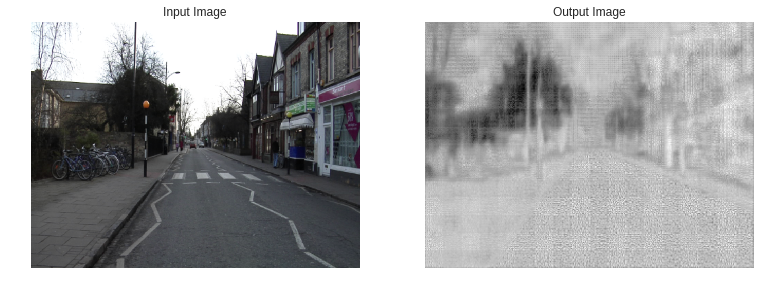

In [0]:
mno = 5
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out2[mno, :, :])
#plt.subplot(1, 3, 3)
#plt.title('Ground Truth')
#plt.axis('off')
#plt.imshow(m_[mno, :, :])
plt.show()

In [0]:
np.max(out2[3, :, :])

4.310632

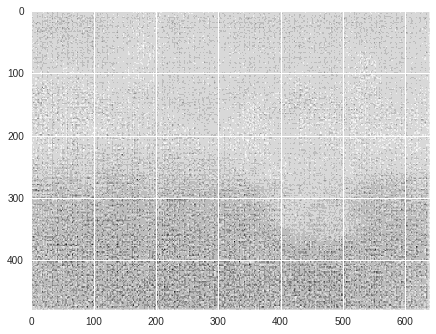

In [0]:
plt.imshow(np.round(out2[7]))
#plt.imshow(out3[21])#.sum(axis=0))

In [0]:
np.max(out2[21])

474

In [0]:
out3 = np.int64(out2).sum(axis=0)

In [0]:
np.bincount(b_.flatten())

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0, 307200])

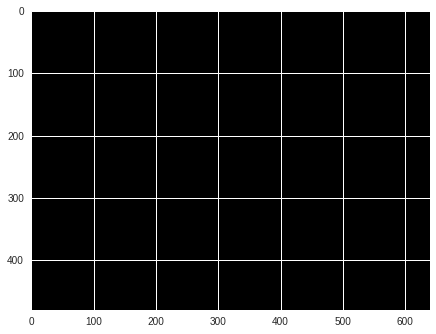

In [0]:
imgt = plt.imread('/content/training/instance/' + '000001_10.png')
b = decode_segmap(b_, plot=True)

In [0]:
def decode_segmap(temp, plot=False):
        Sky = [128, 128, 128]
        Building = [128, 0, 0]
        Pole = [192, 192, 128]
        Road_marking = [255, 69, 0]
        Road = [128, 64, 128]
        Pavement = [60, 40, 222]
        Tree = [128, 128, 0]
        SignSymbol = [192, 128, 128]
        Fence = [64, 64, 128]
        Car = [64, 0, 128]
        Pedestrian = [64, 64, 0]
        Bicyclist = [0, 128, 192]

        label_colours = np.array([Sky, Building, Pole, Road_marking, Road, 
                                  Pavement, Tree, SignSymbol, Fence, Car, 
                                  Pedestrian, Bicyclist]).astype(np.uint8)
        r = np.zeros_like(temp).astype(np.uint8)
        g = np.zeros_like(temp).astype(np.uint8)
        b = np.zeros_like(temp).astype(np.uint8)
        for l in range(0, 12):
            r[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            b[temp == l] = label_colours[l, 2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3)).astype(np.uint8)
        rgb[:, :, 0] = b
        rgb[:, :, 1] = g
        rgb[:, :, 2] = r
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb
        

In [0]:
b__1 = decode_segmap(smg_)
b__ = decode_segmap(b_)

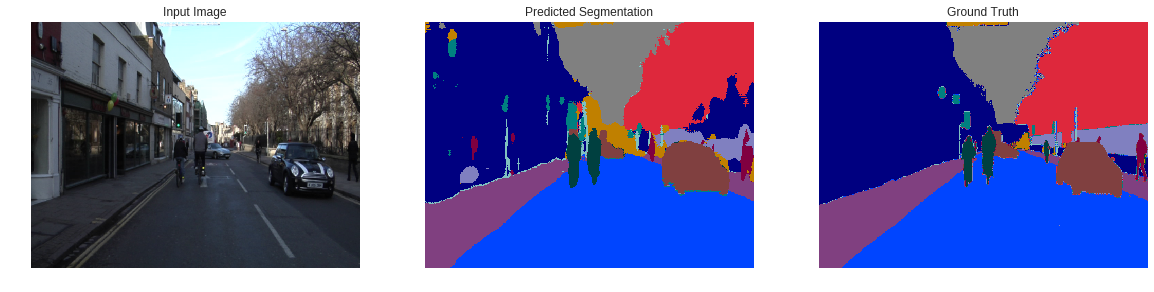

In [0]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(b__)
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(b__1)
plt.show()

In [0]:
# Save the parameters
checkpoint = {
    'epochs' : e,
    'state_dict' : enet.state_dict()
}
torch.save(checkpoint, 'ckpt-enet-1.pth')

In [0]:
# Save the model
torch.save(enet, '/content/model.pt')

In [0]:
enet.eval()

for inputs, labels in testloader:
    if cuda:
        inputs, labels = inputs.cuda(), labels.cuda()

    out = enet(inputs)

    enet.zero_grad()

    loss = criterion(inputs, labels)
    loss.backward()
    optimizer.step()


    train_losses.append(loss)

    if print_every % e == 0:
        print ('Epoch {}/{}'.format(e, epochs),
               'Loss {}'.format(loss))

In [0]:
def loader(training_path, segmented_path, batch_size, h=480, w=640):
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)
    
    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
        
    '''
    if not one_epoch:
        iterations = (total_files_t // batch_size) + 1 if total_files_t % batch_size != 0 else (total_files_t // batch_size)
    else:
        iterations = 1
    '''
    
    idx = 0
    while(1):
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
            
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            img = plt.imread(training_path + filenames_t[jj])
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            inputs.append(img)
            
            img = Image.open(segmented_path + filenames_s[jj])
            img = np.array(img)
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

In [0]:
def create_semantic(mask, color_map):
    assert(len(color_map) == mask.shape[0])
    
    h = mask.shape[1]
    w = mask.shape[2]
    fimg = np.zeros((h, w, 3))
    
    fimg = np.ones((h, w, 3))
    for ii in range(len(color_map)):
        cmask = np.logical_and(fimg, mask[ii, : :])
        
    for ii in range(len(color_map)):
        for hh in range(h):
            for ww in range(w):
                print (hh, ww, fimg[hh, ww, :])
                if fimg[hh, ww, :].sum() == 0:
                    fimg[hh, ww, :] = color_map[ii]
                else:
                    fimg[hh, ww, :] = [0, 0, 0]
                    
    return fimg

In [0]:
b_ = create_semantic(m_, color_map)

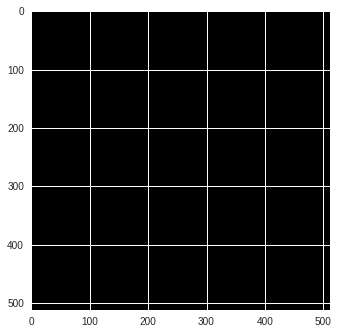

In [0]:
plt.imshow(b_)

In [0]:
pipe = loader('/content/train/', '/content/trainannot/', batch_size)
images, labels = next(pipe)

In [0]:
images.shape

torch.Size([10, 3, 480, 640])

In [0]:
labels.shape

torch.Size([10, 480, 640])

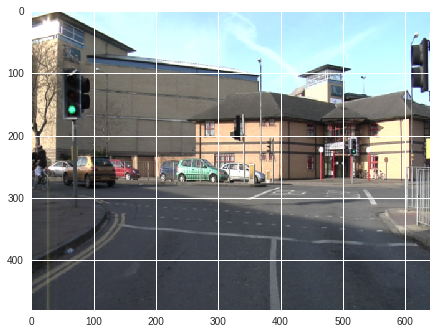

In [0]:
plt.imshow(images[9].transpose(0, 1).transpose(1, 2))

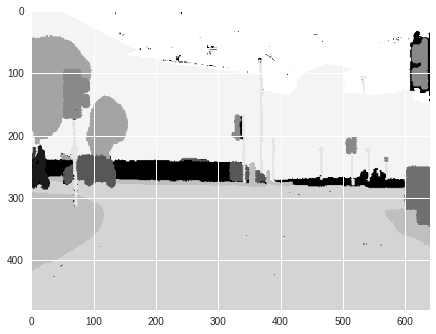

In [0]:
plt.imshow(labels[9])

In [0]:
labels[9][250, 200]

tensor(11, dtype=torch.uint8)

In [0]:
np.unique(labels[9])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8)

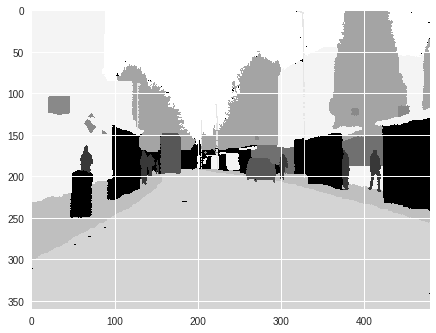

In [0]:
b_ = plt.imread('./0016E5_08640.png')
plt.imshow(b_)

In [0]:
enet2 = ENet(34)

In [0]:
def decode_segmap(temp, plot=False):

        unlabeled = (  0,  0,  0)
        dynamic =  (111, 74,  0)
        ground =   ( 81,  0, 81)
        road =     (128, 64,128)
        sidewalk = (244, 35,232)
        parking =   (250,170,160)
        rail_track = (230,150,140)
        building = ( 70, 70, 70)
        wall =     (102,102,156)
        fence =    (190,153,153)
        guard_rail = (180,165,180)
        bridge = (150,100,100)
        tunnel = (150,120, 90) 
        pole = (153,153,153)
        traffic_light = (250,170, 30)
        traffic_sign = (220,220,  0)
        vegetation = (107,142, 35)
        terrain = (152,251,152)
        sky = ( 70,130,180)
        person = (220, 20, 60)
        rider = (255,  0,  0)
        car = (  0,  0,142)
        truck = (  0,  0, 70)
        bus = (  0, 60,100)
        caravan = (  0,  0, 90)
        trailer = (  0,  0,110)
        train = (  0, 80,100)
        motorcycle = (  0,  0,230)
        license_plate = (119, 11, 32)

        label_colours = np.array([unlabeled, unlabeled, unlabeled, unlabeled, unlabeled,
                                  dynamic, ground, road, sidewalk, parking, rail_track, 
                                  building, wall, fence, guard_rail, bridge, 
                                  tunnel, pole, traffic_light, traffic_sign, vegetation, 
                                  terrain, sky, person, rider, car, truck, bus, caravan,
                                  trailer, train, motorcycle, license_plate]).astype(np.uint8)
        
        r = np.zeros_like(temp).astype(np.uint8)
        g = np.zeros_like(temp).astype(np.uint8)
        b = np.zeros_like(temp).astype(np.uint8)
        for l in range(0, 12):
            r[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            b[temp == l] = label_colours[l, 2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3)).astype(np.uint8)
        rgb[:, :, 0] = b
        rgb[:, :, 1] = g
        rgb[:, :, 2] = r
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

In [0]:
#enet2.cuda()
enet(images.cuda())